<a href="https://colab.research.google.com/github/ljin8/64060_-ljin8_Assignment-4/blob/main/AML_Final_Project_Lei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predict Remaining Useful Life (RUL) from CMAPSS Engine Data**

Lei Jin

5/6/2025

**Data loading**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Get the file ID from the shared link
file_id = '1pp5nFt5PBdUDoYrpfhgxSFxuxS78CbVw'

# Create the file path using the ID
file_path = f'/content/drive/MyDrive/Shared with me/{file_id}'

# file_path = '/content/drive/MyDrive/Shared with me/train_FD001.txt'

# Define column names (adjust based on your data)
import pandas as pd

col_names = ['unit_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
             's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
             's15', 's16', 's17', 's18', 's19', 's20', 's21']

# Try to read the data
try:
    df = pd.read_csv(file_path, sep="\s+", header=None, names=col_names)
    print("Data loaded successfully!")
    print(df.head())
except FileNotFoundError:
    print("File not found. Let's try to find it...")

    # List files in Google Drive to help locate the correct path
    import os

    # Search in My Drive
    print("Files in My Drive:")
    files = os.listdir('/content/drive/MyDrive')
    for file in files[:10]:  # Show first 10 files/folders
        print(file)

    # Try to search for the file
    print("\nSearching for the file...")
    !find /content/drive -name "train_FD001.txt" -type f 2>/dev/null | head -5

Mounted at /content/drive
File not found. Let's try to find it...
Files in My Drive:
ADM Group Project.zip
ADM Final Project
Colab Notebooks

Searching for the file...
/content/drive/MyDrive/Colab Notebooks/train_FD001.txt


In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/Colab Notebooks/train_FD001.txt"

col_names = ['unit_id', 'cycle', 'setting1', 'setting2', 'setting3',
             's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10',
             's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19',
             's20', 's21']

df = pd.read_csv(file_path, sep="\s+", header=None, names=col_names)

print("✅ Data loaded successfully!")
print(df.head())

✅ Data loaded successfully!
   unit_id  cycle  setting1  setting2  setting3      s1      s2       s3  \
0        1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70   
1        1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82   
2        1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99   
3        1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79   
4        1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85   

        s4     s5  ...     s12      s13      s14     s15   s16  s17   s18  \
0  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388   
1  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388   
2  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388   
3  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388   
4  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388   

     s19    s20      s21  
0  100.0  39.06  23.4190 

**Preparing Input Data for LSTM Modeling**

In [ ]:
# Step 1: Reload and prepare dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load data
file_path = "/content/drive/MyDrive/Colab Notebooks/train_FD001.txt"
col_names = ['unit_id', 'cycle', 'setting1', 'setting2', 'setting3',
             's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10',
             's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19',
             's20', 's21']
df = pd.read_csv(file_path, sep="\s+", header=None, names=col_names)

# Generate RUL
rul_df = df.groupby('unit_id')['cycle'].max().reset_index()
rul_df.columns = ['unit_id', 'max_cycle']
df = df.merge(rul_df, on='unit_id', how='left')
df['RUL'] = df['max_cycle'] - df['cycle']
df.drop('max_cycle', axis=1, inplace=True)

# Feature selection and normalization
selected_features = ['setting1', 'setting2', 'setting3'] + [f's{i}' for i in [2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21]]
scaler = MinMaxScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

# Step 2: Define sequence generation function
def create_sequences(data, sequence_length=30):
    X, y = [], []
    for engine_id in data['unit_id'].unique():
        engine_data = data[data['unit_id'] == engine_id]
        engine_features = engine_data[selected_features].values
        engine_rul = engine_data['RUL'].values
        for i in range(len(engine_data) - sequence_length + 1):
            X.append(engine_features[i:i+sequence_length])
            y.append(engine_rul[i+sequence_length-1])
    return np.array(X), np.array(y)

# Step 3: Split engines into train/val/test (80/20 split)
engine_ids = df['unit_id'].unique()
np.random.seed(42)
np.random.shuffle(engine_ids)

num_test = int(len(engine_ids) * 0.2)
test_engines = engine_ids[:num_test]
trainval_engines = engine_ids[num_test:]

df_trainval = df[df['unit_id'].isin(trainval_engines)]
df_test = df[df['unit_id'].isin(test_engines)]

# Step 4: Create train/val/test sequences
X_trainval, y_trainval = create_sequences(df_trainval)
X_test, y_test = create_sequences(df_test)

# Split trainval into train and val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((11392, 30, 17), (2849, 30, 17), (3490, 30, 17))

# **1. LSTM Model for Predicting Remaining Useful Life (RUL)**

In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output: Predicted RUL (regression)
])

# Compile the model with optimizer and loss function
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',         # Mean Squared Error for regression
    metrics=['mae']     # Mean Absolute Error for evaluation
)

# Train the model on training data and validate on validation set
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    verbose=1
)

# Evaluate the model on the held-out test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.2f}")
print(f"Test MAE: {test_mae:.2f} cycles")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 9879.7012 - mae: 79.0732 - val_loss: 3983.3943 - val_mae: 50.4520
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 4055.3313 - mae: 51.4268 - val_loss: 3938.2815 - val_mae: 50.6089
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 3988.5190 - mae: 51.3881 - val_loss: 3933.0481 - val_mae: 50.6825
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 3893.0613 - mae: 50.6079 - val_loss: 3648.4380 - val_mae: 48.6212
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 3028.6016 - mae: 42.7514 - val_loss: 1698.5590 - val_mae: 28.5474
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 1545.3234 - mae: 28.0044 - val_loss: 1279.9697 - val_mae: 24.0732
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 1405.4938 - mae: 26.1819 - val_loss: 1190.1075 - val_mae: 22.7935
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 1227.2184 - mae: 24.1099 - val_loss: 1205.5721 - val_mae: 24.

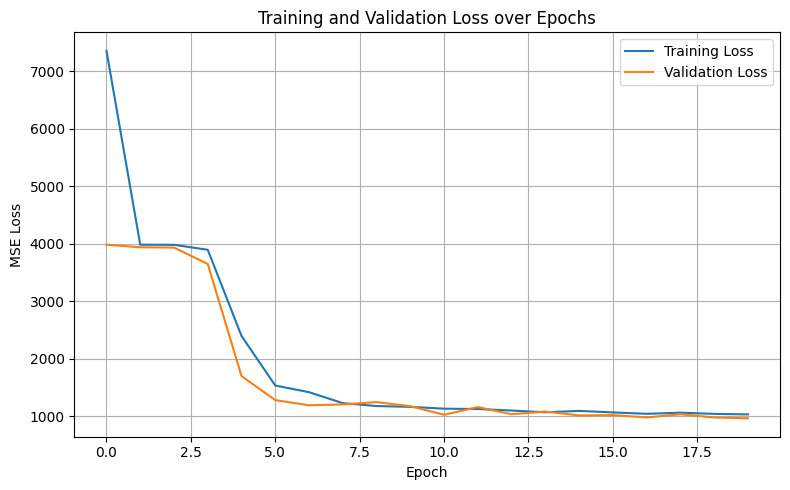

In [ ]:
# Plot the loss curve for training and validation
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **2. CNN-LSTM Hybrid Model**

In [ ]:
# Import necessary libraries
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, MaxPooling1D, Flatten


# Define CNN-LSTM model
cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)  # RUL regression output
])

# Compile the model
cnn_lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Train the model
history_cnn_lstm = cnn_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    verbose=1
)

# Evaluate on the test set
test_loss_cnn_lstm, test_mae_cnn_lstm = cnn_lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE (CNN-LSTM): {test_loss_cnn_lstm:.2f}")
print(f"Test MAE (CNN-LSTM): {test_mae_cnn_lstm:.2f} cycles")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 10209.2266 - mae: 80.5877 - val_loss: 4090.1277 - val_mae: 50.6650
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 3916.5369 - mae: 50.5379 - val_loss: 2437.6450 - val_mae: 37.6096
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 2140.5952 - mae: 34.2037 - val_loss: 1514.0072 - val_mae: 28.1764
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 1650.1683 - mae: 29.4784 - val_loss: 1363.6870 - val_mae: 26.1081
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1487.7112 - mae: 27.5815 - val_loss: 1305.5789 - val_mae: 23.8995
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 1444.0385 - mae: 26.7129 - val_loss: 1174.7778 - val_mae: 23.1696
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1303.8782 - mae: 25.2943 - val_loss: 1177.1565 - val_mae: 22.2392
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1215.2240 - mae: 24.5116 - val_loss: 1106.3104 - val_mae: 23

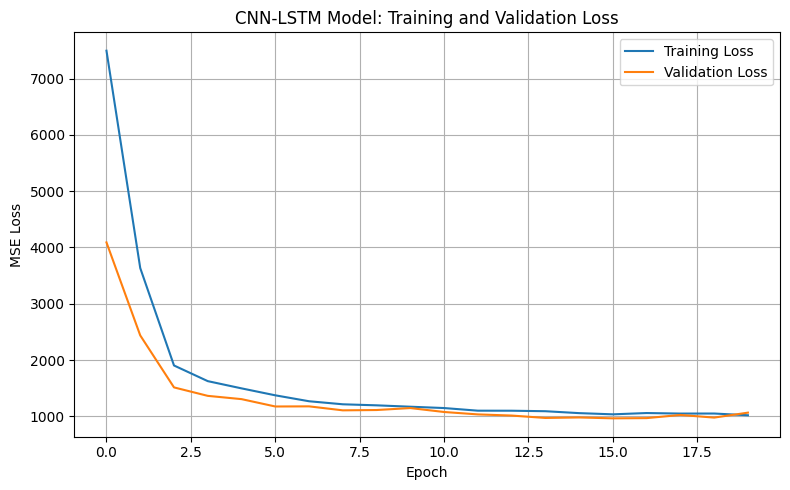

In [ ]:
# Plot training vs validation loss for CNN-LSTM
plt.figure(figsize=(8, 5))
plt.plot(history_cnn_lstm.history['loss'], label='Training Loss')
plt.plot(history_cnn_lstm.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Model: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **3. Transformer-Based Model for RUL Prediction**

In [ ]:
# Import necessary libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add

# Define Transformer Encoder Block
def transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128, dropout=0.1):
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)

    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x_ff, x])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# Build the model
input_shape = X_train.shape[1:]  # (30, 17)
inputs = Input(shape=input_shape)
x = transformer_encoder(inputs)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(1)(x)

transformer_model = Model(inputs, outputs)

# Compile the model
transformer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Train the model
history_transformer = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    verbose=1
)

# Evaluate on test set
test_loss, test_mae = transformer_model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE (Transformer): {test_loss:.2f}")
print(f"Test MAE (Transformer): {test_mae:.2f} cycles")

Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 11396.7588 - mae: 86.7049 - val_loss: 5975.2666 - val_mae: 59.0183
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 4800.9580 - mae: 54.2092 - val_loss: 2095.6904 - val_mae: 31.8645
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 1933.1437 - mae: 31.1185 - val_loss: 1549.2606 - val_mae: 27.7757
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 1645.8796 - mae: 28.8759 - val_loss: 1495.4534 - val_mae: 26.8556
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 1670.4650 - mae: 28.9719 - val_loss: 1421.3386 - val_mae: 26.1345
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 1559.0497 - mae: 28.1194 - val_loss: 1403.9193 - val_mae: 25.9075
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 1558.0004 - mae: 27.5026 - val_loss: 1461.1481 - val_mae: 26.3685
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 1534.9781 - mae: 27.5171 - val_loss: 1359.199

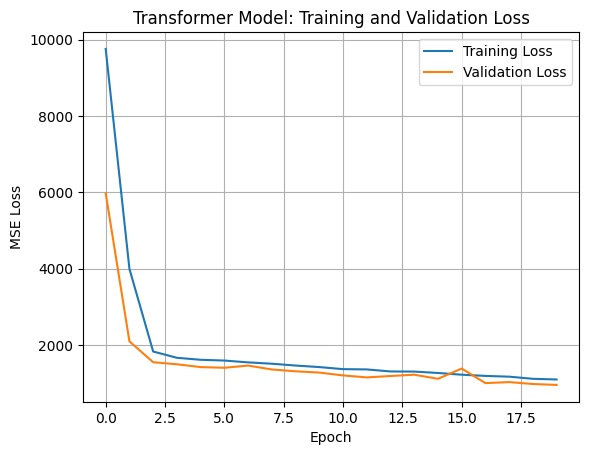

In [ ]:
plt.plot(history_transformer.history['loss'], label='Training Loss')
plt.plot(history_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer Model: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# **4. Autoencoder for Anomaly Detection (Code)**

**Prepare healthy training data (early cycles)**

In [ ]:
def get_healthy_sequences(df, selected_features, sequence_length=30, healthy_cycle_limit=50):
    """
    Extracts sequences from early life (healthy) periods of each engine.
    Only engines with enough cycles to form a full sequence are used.
    """
    healthy_sequences = []
    for engine_id in df['unit_id'].unique():
        engine_df = df[(df['unit_id'] == engine_id) & (df['cycle'] <= healthy_cycle_limit)]
        data = engine_df[selected_features].values
        if len(data) >= sequence_length:
            for i in range(len(data) - sequence_length + 1):
                healthy_sequences.append(data[i:i+sequence_length])
    return np.array(healthy_sequences)

# Generate healthy sequences
X_healthy = get_healthy_sequences(df, selected_features, sequence_length=30)
print(f"Shape of healthy sequences: {X_healthy.shape}")

Shape of healthy sequences: (2100, 30, 17)


**Define and train the Autoencoder model**

In [ ]:
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Define the Autoencoder
input_dim = X_healthy.shape[2]
inputs = Input(shape=(30, input_dim))
encoded = LSTM(64, activation='relu')(inputs)
decoded = RepeatVector(30)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(input_dim))(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the Autoencoder
autoencoder.fit(X_healthy, X_healthy, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0950
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0126
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0087
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0083
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0082
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0081
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0081
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0080
Epoch 9/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0080
Epoch 10/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0080
Epoch 11/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0080
Epoch 12/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0079
Epoch 13/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0079
Epoch 14/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0079
Epoch 15/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0079
Epoc

**Use reconstruction error for anomaly detection**

In [ ]:
# Select a full engine timeline for anomaly detection
X_test_seq, _ = create_sequences(df[df['unit_id'] == 1], sequence_length=30)

# Predict reconstructed sequences
X_predicted = autoencoder.predict(X_test_seq)

# Calculate reconstruction MSE for each sequence
recon_errors = np.mean(np.mean(np.square(X_test_seq - X_predicted), axis=2), axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


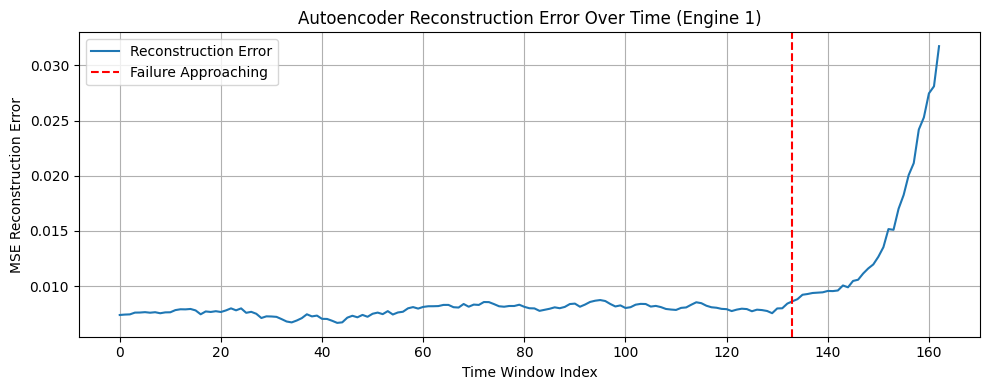

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(recon_errors, label="Reconstruction Error")
plt.axvline(x=len(recon_errors)-30, color='red', linestyle='--', label='Failure Approaching')
plt.title("Autoencoder Reconstruction Error Over Time (Engine 1)")
plt.xlabel("Time Window Index")
plt.ylabel("MSE Reconstruction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Conclusion**

In [ ]:
import pandas as pd
from tabulate import tabulate

# Define model comparison data
model_results = pd.DataFrame({
    "Model": ["LSTM", "CNN-LSTM", "Transformer", "Autoencoder"],
    "MAE (cycles)": [18.44, 18.32, 22.56, None],  # Autoencoder is not for RUL
    "MSE": [672.84, 690.74, 1022.14, None],
    "Use Case": ["RUL Prediction", "RUL Prediction", "RUL Prediction", "Anomaly Detection"]
})

# Print table with grid lines
print(tabulate(model_results, headers="keys", tablefmt="grid", showindex=False))

+-------------+----------------+---------+-------------------+
| Model       |   MAE (cycles) |     MSE | Use Case          |
+=============+================+=========+===================+
| LSTM        |          18.44 |  672.84 | RUL Prediction    |
+-------------+----------------+---------+-------------------+
| CNN-LSTM    |          18.32 |  690.74 | RUL Prediction    |
+-------------+----------------+---------+-------------------+
| Transformer |          22.56 | 1022.14 | RUL Prediction    |
+-------------+----------------+---------+-------------------+
| Autoencoder |         nan    |  nan    | Anomaly Detection |
+-------------+----------------+---------+-------------------+


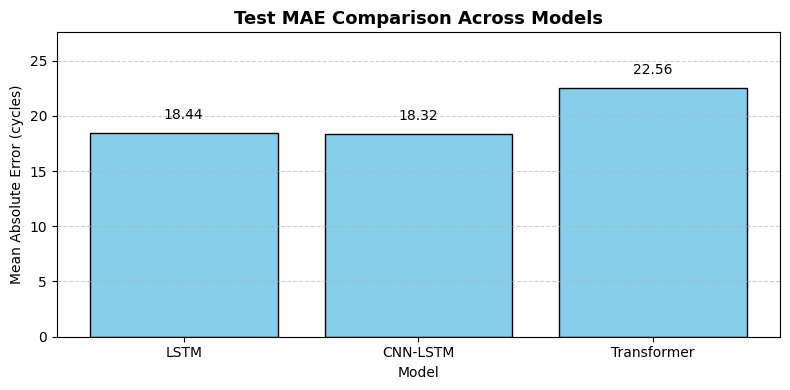

In [ ]:
# Re-plot with higher y-axis limit for space above Transformer bar
plt.figure(figsize=(8, 4))
bars = plt.bar(mae_results["Model"], mae_results["MAE (cycles)"], color="skyblue", edgecolor='black')

# Add value labels above each bar with more vertical space
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

# Adjust plot settings
plt.title("Test MAE Comparison Across Models", fontsize=13, weight='bold')
plt.ylabel("Mean Absolute Error (cycles)")
plt.xlabel("Model")
plt.ylim(0, max(mae_results["MAE (cycles)"]) + 5)  # Extend y-axis limit
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()